In [3]:
# uncomment if you're don't have wget
#pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=b206fe2e22dd1eeb852117fb3ec7415573312f7162ba03fa95795a52ef4577f0
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wget
import torch
import os
%matplotlib inline

In [90]:
#константы
LINK = 'https://api.blockchain.info/charts/market-price?format=csv'
LINK2 = ''
percentage = 100

In [91]:
#импорт данных
if not os.path.exists('market-price.csv'):
    wget.download(LINK, "market-price.csv")
data = pd.read_csv('market-price.csv')
data = data.rename(columns={data.columns[0]: "Date", data.columns[1]: "Price"})[:int(len(data.values)*percentage/100)]
prices = torch.Tensor(data['Price'].values)

In [93]:
#рассчет доходностей
data['r'] = data['Price'][1:].reset_index(drop=True)/data['Price'][:-1].reset_index(drop=True) - 1
r = prices[1:]/prices[:-1] - 1

In [94]:
data

,Date,Price,r
0,2021-03-21 00:00:00,58085.80,-0.011614
1,2021-03-22 00:00:00,57411.17,-0.055846
2,2021-03-23 00:00:00,54204.96,0.005027
3,2021-03-24 00:00:00,54477.46,-0.036148
4,2021-03-25 00:00:00,52508.23,-0.020803
...,...,...,...
360,2022-03-16 00:00:00,39320.82,0.046089
361,2022-03-17 00:00:00,41133.08,-0.004529
362,2022-03-18 00:00:00,40946.78,0.020734
363,2022-03-19 00:00:00,41795.77,0.010206


In [95]:
#рассчет скользящих средник 
short = 5
long = 12
data['SMA'] = data['Price'].rolling(short).mean()
data['LMA'] = data['Price'].rolling(long).mean()

In [96]:
data

,Date,Price,r,SMA,LMA
0,2021-03-21 00:00:00,58085.80,-0.011614,NaN,NaN
1,2021-03-22 00:00:00,57411.17,-0.055846,NaN,NaN
2,2021-03-23 00:00:00,54204.96,0.005027,NaN,NaN
3,2021-03-24 00:00:00,54477.46,-0.036148,NaN,NaN
4,2021-03-25 00:00:00,52508.23,-0.020803,55337.524,NaN
...,...,...,...,...,...
360,2022-03-16 00:00:00,39320.82,0.046089,38874.406,39125.047500
361,2022-03-17 00:00:00,41133.08,-0.004529,39352.814,39291.033333
362,2022-03-18 00:00:00,40946.78,0.020734,39780.334,39419.966667
363,2022-03-19 00:00:00,41795.77,0.010206,40575.410,39702.306667


In [97]:
def moving_average(X: torch.Tensor, width: int) -> torch.Tensor:
    ret:torch.Tensor = torch.cumsum(X, dim=0)
    ret[width:] = ret[width:] - ret[:-width]
    return ret[width - 1:] / width

r = prices[1:]/prices[:-1] - 1
short_moving = moving_average(prices, short)[long-short:-1]
long_moving = moving_average(prices, long)[:-1]
r = r[long-1:]
short_moving.size(0), long_moving.size(0), r.size(0)

(353, 353, 353)

In [98]:
#Избавляемся от ненужных строк
data = data.drop(len(data)-1)
data = data.drop(data.index[0:long-1])

In [99]:
#рассчитываем доходность стратегии
data['strategy'] = data['r']*(data['SMA']>data['LMA']) - data['r']*(data['SMA']<data['LMA'])


In [100]:
strat = r * (short_moving > long_moving) - r * (short_moving < long_moving)

In [101]:
data

,Date,Price,r,SMA,LMA,strategy
11,2021-04-01 00:00:00,58735.25,0.000028,57348.138,55826.558333,0.000028
12,2021-04-02 00:00:00,58736.92,0.005012,57922.736,55880.818333,0.005012
13,2021-04-03 00:00:00,59031.32,-0.033115,58572.258,56015.830833,-0.033115
14,2021-04-04 00:00:00,57076.49,0.019799,58462.022,56255.125000,0.019799
15,2021-04-05 00:00:00,58206.55,0.014561,58357.306,56565.882500,0.014561
...,...,...,...,...,...,...
359,2022-03-15 00:00:00,39680.60,-0.009067,38897.820,39387.012500,0.009067
360,2022-03-16 00:00:00,39320.82,0.046089,38874.406,39125.047500,-0.046089
361,2022-03-17 00:00:00,41133.08,-0.004529,39352.814,39291.033333,-0.004529
362,2022-03-18 00:00:00,40946.78,0.020734,39780.334,39419.966667,0.020734


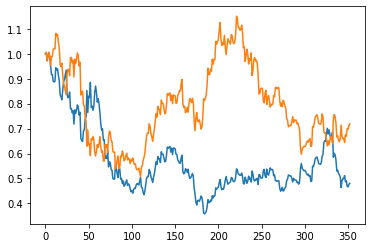

In [102]:
plt.plot(torch.cumprod(1 + strat, dim=0))
plt.plot(torch.cumprod(1 + r, dim=0))
plt.show()

Годовая доходность стратегии скользящих средних -41.21%
Годовая доходность стратегии buy and hold -21.29%


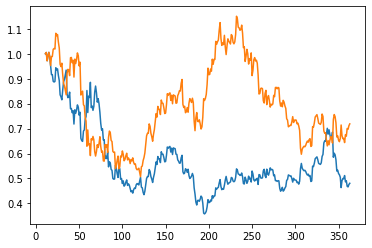

In [103]:
#визуализируем результаты
plt.plot(np.cumprod(1+data['strategy']))
plt.plot(np.cumprod(1+data['r']))
r_strat = np.prod(1+data['strategy'])**(256/len(data['strategy'])) - 1
r_bnh = np.prod(1+data['r'])**(256/len(data['r'])) - 1
print('Годовая доходность стратегии скользящих средних '+str(round(r_strat*100,2))+'%')
print('Годовая доходность стратегии buy and hold '+str(round(r_bnh*100,2))+'%')

In [109]:
#функции для подсчета доходностей
def profitability_bnh(prices: torch.Tensor):
    """
      Доходность стратегии Buy and hold за весь период
    """
    r = prices[1:]/prices[:-1] - 1
    return torch.prod(1 + r, dim=0) - 1

def profability_mooving_average(prices: torch.Tensor, short: int, long: int):
    """
      Доходность скользящих средних за весь период
    """
    r = prices[1:]/prices[:-1] - 1
    short_moving = moving_average(prices, short)[long-short:-1]
    long_moving = moving_average(prices, long)[:-1]
    r = r[long-1:]
    strat = r * (short_moving > long_moving) - r * (short_moving < long_moving)
    return torch.prod(1 + strat, dim=0) - 1

In [112]:
profitability_bnh(prices), profability_mooving_average(prices, 3, 20)

(tensor(-0.2731), tensor(-0.1947))